In [1]:
import json
import os

from IPython.display import display, Markdown
import matplotlib
import matplotlib.pyplot as plt
import pandas
import numpy as np

In [2]:
target = 'b/2020-10-19_18-51-07/rmw_cyclonedds_cpp_Array1k@30_reliable_volatile_keep_last@10_1000bw_0loss_0delay'

list_of_directories = os.listdir(target)
list_of_directories = [os.path.join(target, x) for x in list_of_directories]
list_of_directories = [x for x in list_of_directories if os.path.isdir(x)]

list_of_experiments = []
for directory in list_of_directories:
#     nested_dirs = os.listdir(directory)
#     for nested_dir in nested_dirs:
    nested_dir = ''
    with open(os.path.join(directory, nested_dir, 'experiment_config.json')) as fp:
        list_of_experiments.append(json.load(fp))
        list_of_experiments[-1]['directory'] = os.path.join(directory, nested_dir)

df_init = {k: [] for k in list_of_experiments[0].keys()}
for experiment in list_of_experiments:
    assert df_init.keys() == experiment.keys()
    for (k, v) in experiment.items():
        df_init[k].append(v)

df = pandas.DataFrame(df_init)

In [3]:
def read_performance_test_csv(csv_path, start_marker='---EXPERIMENT-START---\n'):
    with open(csv_path, 'r') as csv:
        if start_marker:
            while csv.readline() not in [start_marker, '']:
                pass
        return pandas.read_csv(csv, sep='[ \t]*,[ \t]*', engine='python')

In [4]:
# Parse source data.
import glob

for experiment in list_of_experiments:
    pub_logs = glob.glob(os.path.join(experiment['directory'], 'pub_log_*'))
    assert len(pub_logs) == 1
    experiment['pub_log'] = read_performance_test_csv(pub_logs[0])

    sub_logs = glob.glob(os.path.join(experiment['directory'], 'sub_log_*'))
    assert len(sub_logs) == 1
    experiment['sub_log'] = read_performance_test_csv(sub_logs[0])

In [5]:
# Generate new histogram plots from source data.
for e in list_of_experiments:
    tdf = pandas.DataFrame({
        'Sent by Publisher': e['pub_log'].sent,
        'Received by Subscription': e['sub_log'].received,
    })
    tdf.index += 1  # Index from 1, since the index is really time in seconds
    ax = tdf.plot(kind='bar')
    title = \
        f"{e['message_type']}@{e['message_rate']} 1 to 1 Pub/Sub in separate processes, single machine\n" + \
        f"{e['rmw_implementation']}, {e['reliability']}, {e['durability']}, " + \
        ('keep_all' if e['history_kind'] == 'keep_all' else f"keep_last@{e['history_depth']}") + '\n' + \
        f"bandwidth: {e['bandwidth']}Mbps, packet loss: {e['loss']}%, delay: {e['delay']}ms"
    ax.set_title(title)
    ax.set_xlabel('Time in Seconds')
    ax.set_ylabel('Number of Messages')
    ax.get_figure().savefig(os.path.join(e['directory'], 'new_histogram.svg'), bbox_inches='tight')
    plt.close()

In [6]:
imgs = glob.glob(os.path.join(target, '*/new_histogram.svg'))

Markdown(f"""
<table>
  <tr>
    <td>A</td>
    <td>B</td>
    <td>C</td>
    <td>D</td>
    <td>E</td>
  </tr>
  <tr>
    <td valign="top"><img src="{imgs[0]}"></td>
    <td valign="top"><img src="{imgs[1]}"></td>
    <td valign="top"><img src="{imgs[2]}"></td>
    <td valign="top"><img src="{imgs[3]}"></td>
    <td valign="top"><img src="{imgs[4]}"></td>
  </tr>
</table>
""")


<table>
  <tr>
    <td>A</td>
    <td>B</td>
    <td>C</td>
    <td>D</td>
    <td>E</td>
  </tr>
  <tr>
    <td valign="top"><img src="b/2020-10-19_18-51-07/rmw_cyclonedds_cpp_Array1k@30_reliable_volatile_keep_last@10_1000bw_0loss_0delay/run01/new_histogram.svg"></td>
    <td valign="top"><img src="b/2020-10-19_18-51-07/rmw_cyclonedds_cpp_Array1k@30_reliable_volatile_keep_last@10_1000bw_0loss_0delay/run02/new_histogram.svg"></td>
    <td valign="top"><img src="b/2020-10-19_18-51-07/rmw_cyclonedds_cpp_Array1k@30_reliable_volatile_keep_last@10_1000bw_0loss_0delay/run05/new_histogram.svg"></td>
    <td valign="top"><img src="b/2020-10-19_18-51-07/rmw_cyclonedds_cpp_Array1k@30_reliable_volatile_keep_last@10_1000bw_0loss_0delay/run03/new_histogram.svg"></td>
    <td valign="top"><img src="b/2020-10-19_18-51-07/rmw_cyclonedds_cpp_Array1k@30_reliable_volatile_keep_last@10_1000bw_0loss_0delay/run04/new_histogram.svg"></td>
  </tr>
</table>


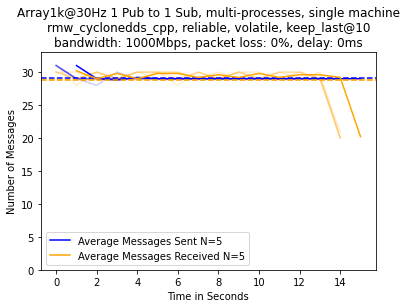

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_xlabel('Time in Seconds')
ax.set_ylabel('Number of Messages')

pub_datasets = []
sub_datasets = []

for e in list_of_experiments:
    ax.plot(e['pub_log'].sent, color='blue', alpha=0.2)
    pub_datasets.append(e['pub_log'].sent)
    pub_datasets[-1].index = range(1, len(e['pub_log'].sent) + 1)
    ax.plot(e['sub_log'].received, color='orange', alpha=0.2)
    ax.axhline(y=e['sub_log'].received.mean(), color='orange', linestyle='--', alpha=0.2)
    sub_datasets.append(e['sub_log'].received)
    sub_datasets[-1].index = range(1, len(e['sub_log'].received) + 1)

runs = len(list_of_experiments)
pubs = pandas.DataFrame(np.array(pub_datasets).mean(axis=0))
pubs.index += 1
ax.plot(pubs, color='blue', label=f'Average Messages Sent N={runs}')
ax.axhline(
    y=np.array(pub_datasets).mean(axis=0).mean(), color='blue', linestyle='--',
#     label='Mean of Average Messages Received',
)
subs = pandas.DataFrame(np.array(sub_datasets).mean(axis=0))
subs.index += 1
ax.plot(subs, color='orange', label=f'Average Messages Received N={runs}')
ax.axhline(
    y=np.array(sub_datasets).mean(axis=0).mean(), color='orange', linestyle='--',
#     label='Mean of Average Messages Received',
)

ax.legend()

e = list_of_experiments[0]
title = \
    f"{e['message_type']}@{e['message_rate']}Hz 1 Pub to 1 Sub, multi-processes, single machine\n" + \
    f"{e['rmw_implementation']}, {e['reliability']}, {e['durability']}, " + \
    ('keep_all' if e['history_kind'] == 'keep_all' else f"keep_last@{e['history_depth']}") + '\n' + \
    f"bandwidth: {e['bandwidth']}Mbps, packet loss: {e['loss']}%, delay: {e['delay']}ms"
ax.set_title(title)

ax.set_ylim((0, int(1.1 * int(e['message_rate']))))

ax.get_figure().savefig(os.path.join(target, 'average_sent_received.svg'), bbox_inches='tight')
ax.get_figure().savefig(os.path.join(target, 'average_sent_received.png'), bbox_inches='tight')

In [8]:
import sys
sys.path.insert(0, os.path.join(os.getcwd(), '..', '..', 'demos'))

from plotting.performance import collect_experiments

In [30]:
exps = collect_experiments('f')

In [32]:
exps = list(exps.values())[0]

In [33]:
exps

,directory,run,pub_log,sub_log,rmw_implementation,async_pub,bandwidth,loss,delay,message_rate,message_type,reliability,durability,history_kind,history_depth
0,f/2020-10-23_10-47-36/rmw_cyclonedds_cpp_sync_...,9,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_cyclonedds_cpp,sync,54,30,0,30,Array1k,reliable,volatile,keep_last,10
1,f/2020-10-23_10-47-36/rmw_cyclonedds_cpp_sync_...,1,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_cyclonedds_cpp,sync,54,30,0,30,Array1k,reliable,volatile,keep_last,10
2,f/2020-10-23_10-47-36/rmw_cyclonedds_cpp_sync_...,2,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_cyclonedds_cpp,sync,54,30,0,30,Array1k,reliable,volatile,keep_last,10
3,f/2020-10-23_10-47-36/rmw_cyclonedds_cpp_sync_...,5,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_cyclonedds_cpp,sync,54,30,0,30,Array1k,reliable,volatile,keep_last,10
4,f/2020-10-23_10-47-36/rmw_cyclonedds_cpp_sync_...,6,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_cyclonedds_cpp,sync,54,30,0,30,Array1k,reliable,volatile,keep_last,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,f/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_P...,3,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_fastrtps_cpp,async,1000,0,0,30,PointCloud512k,reliable,volatile,keep_last,10
896,f/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_P...,10,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_fastrtps_cpp,async,1000,0,0,30,PointCloud512k,reliable,volatile,keep_last,10
897,f/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_P...,4,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_fastrtps_cpp,async,1000,0,0,30,PointCloud512k,reliable,volatile,keep_last,10
898,f/2020-10-23_10-47-36/rmw_fastrtps_cpp_async_P...,8,T_experiment T_loop received sent lo...,T_experiment T_loop received sent lo...,rmw_fastrtps_cpp,async,1000,0,0,30,PointCloud512k,reliable,volatile,keep_last,10


In [27]:
# exps.groupby(['bandwidth'])
# df = exps.loc[list(exps.groupby(['bandwidth']).groups.values())[0]]
# df = df.drop('run', 1).drop('pub_log', 1).drop('sub_log', 1).drop_duplicates()
# df
# (list(exps.sort_values('loss')[['loss', 'directory']]['directory']),
# set(exps.sort_values('loss')['directory']))

In [34]:
from plotting.performance import generate_averaged_plot

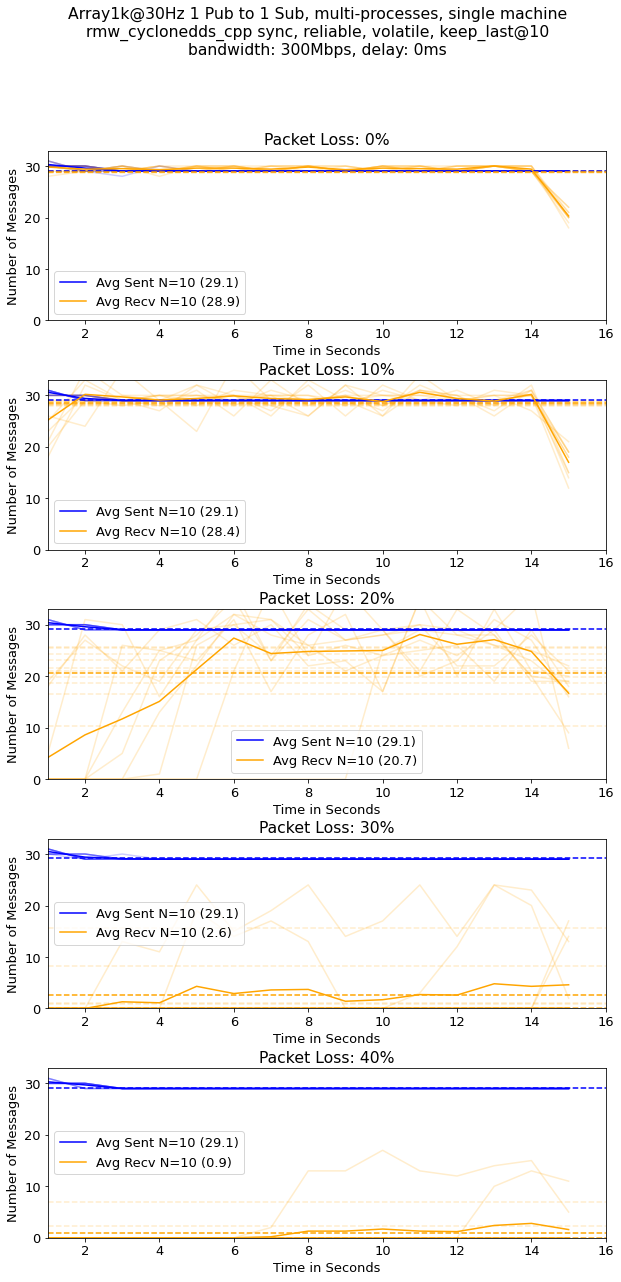

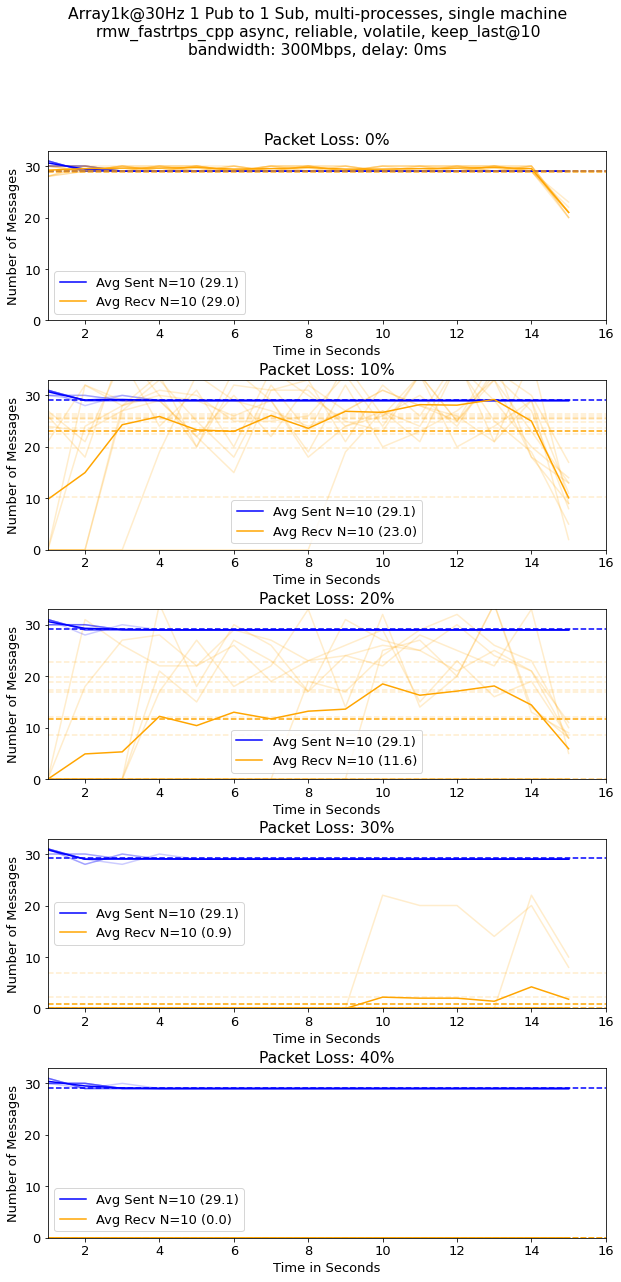

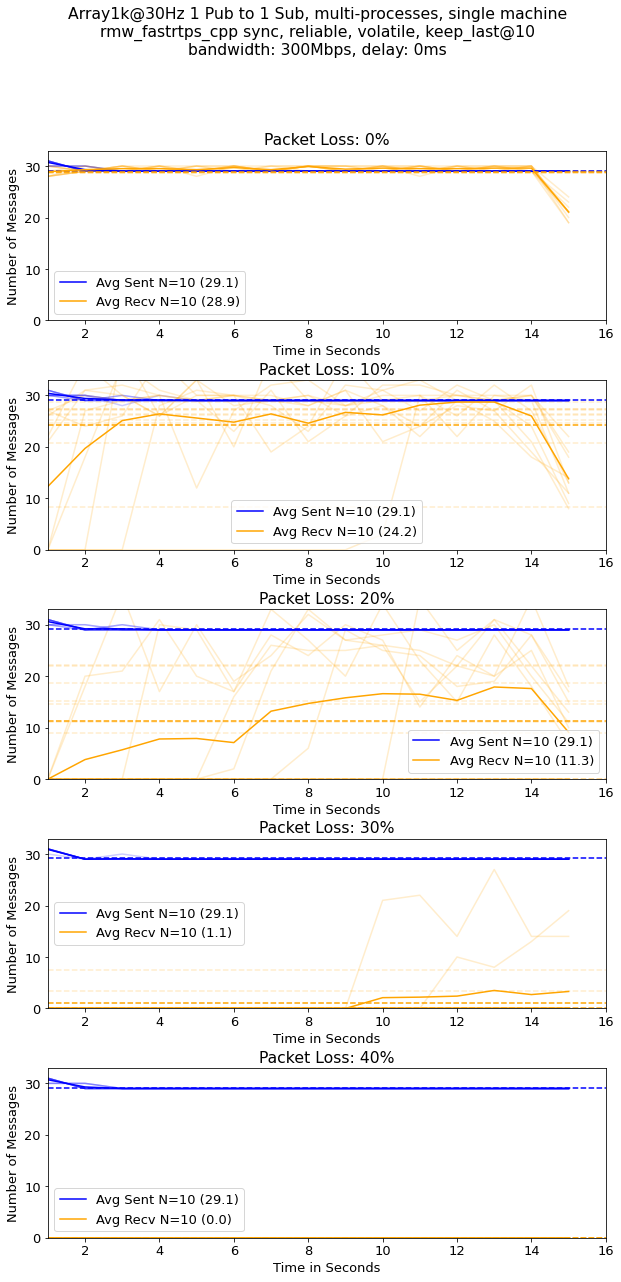

In [36]:
def generate_averaged_plot2(df, *, ax=None):
    if ax is None:
        fig, ax = plt.subplots(nrows=1, ncols=1)
#     ax.set_xlabel('Time in Seconds')
#     ax.set_ylabel('Number of Messages')

    pub_datasets = []
    sub_datasets = []

    for index, row in df.iterrows():
        ax.plot(row['pub_log'].sent, color='blue', alpha=0.2)
        pub_datasets.append(row['pub_log'].sent)
        ax.plot(row['sub_log'].received, color='orange', alpha=0.2)
        ax.axhline(y=row['sub_log'].received.mean(), color='orange', linestyle='--', alpha=0.2)
        sub_datasets.append(row['sub_log'].received)

    number_of_runs = len(df)

    pubs_mean = pandas.DataFrame(pub_datasets).mean(axis=0)
    pubs_mean_mean = pubs_mean.mean()
    ax.plot(
        pubs_mean, color='blue',
        label=f'Avg Sent N={number_of_runs} ({pubs_mean_mean:1.1f})')
    ax.axhline(y=pubs_mean_mean, color='blue', linestyle='--')

    subs_mean = pandas.DataFrame(sub_datasets).mean(axis=0)
    subs_mean_mean = subs_mean.mean()
    ax.plot(
        subs_mean, color='orange',
        label=f'Avg Recv N={number_of_runs} ({subs_mean_mean:1.1f})')
    ax.axhline(y=subs_mean_mean, color='orange', linestyle='--')

    ax.legend()

    e = df.iloc[0]
    title = f"Packet Loss: {e['loss']}%"
#     title = \
#         f"{e['message_type']}@{e['message_rate']}Hz 1 Pub to 1 Sub, multi-processes, single machine\n" + \
#         f"{e['rmw_implementation']}, {e['reliability']}, {e['durability']}, " + \
#         ('keep_all' if e['history_kind'] == 'keep_all' else f"keep_last@{e['history_depth']}") + '\n' + \
#         f"bandwidth: {e['bandwidth']}Mbps, packet loss: {e['loss']}%, delay: {e['delay']}ms"
    ax.set_title(title)

    ax.set_ylim((0, int(1.1 * int(e['message_rate']))))
    ax.set_xlim((1, len(e['pub_log'].sent) + 1))


matplotlib.rc('font', size=13)
experiements_df = exps
df_groupby_bandwidth = experiements_df.groupby(['bandwidth'])
for bw_group, bw_indexes in df_groupby_bandwidth.groups.items():
    if bw_group != 300:
        continue
    df_groupby_message_type_and_rate = \
        experiements_df.loc[bw_indexes].groupby(['message_type', 'message_rate'])
    for mtr_group, mtr_indexes in df_groupby_message_type_and_rate.groups.items():
        mtr_df = experiements_df.loc[mtr_indexes]
        df_groupby_rmw = \
            experiements_df.loc[mtr_indexes].groupby(['rmw_implementation', 'async_pub'])
        for rmw_group, rmw_indexes in df_groupby_rmw.groups.items():
            fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10,20))
            rmw_df = experiements_df.loc[rmw_indexes]
            for i in range(0, 5):
                generate_averaged_plot2(rmw_df[rmw_df.loss == i * 10], ax=axes[i])
            e = rmw_df.iloc[0]
#                 title = f"Packet Loss: {e['loss']}%"
            title = \
                f"{e['message_type']}@{e['message_rate']}Hz 1 Pub to 1 Sub, multi-processes, single machine\n" + \
                f"{e['rmw_implementation']} {e['async_pub']}, {e['reliability']}, {e['durability']}, " + \
                ('keep_all' if e['history_kind'] == 'keep_all' else f"keep_last@{e['history_depth']}") + '\n' + \
                f"bandwidth: {e['bandwidth']}Mbps, delay: {e['delay']}ms"
            fig.suptitle(title)
            for ax in axes:
                ax.set_xlabel('Time in Seconds')
            for ax in axes:
                ax.set_ylabel('Number of Messages')
#             break
            plt.subplots_adjust(wspace=0, hspace=0.35)
        break
    break

In [26]:
a = exps[['rmw_implementation', 'async_pub']]
set([(x['rmw_implementation'], x['async_pub']) for i, x in a.iterrows()])

{('rmw_cyclonedds_cpp', 'sync'),
 ('rmw_fastrtps_cpp', 'async'),
 ('rmw_fastrtps_cpp', 'sync')}